In [1]:
import pandas as pd
import altair as alt
import numpy as np
import seaborn as sns
import altair_saver

%matplotlib inline
import matplotlib.pyplot as plt

sns.set(font_scale=1.5)
sns.set_style("white")

alt.data_transformers.disable_max_rows()
# alt.data_transformers.enable('json')

DataTransformerRegistry.enable('default')

In [2]:
def subset(df, cols):
    """Takes a dataframe, columns to select from df as list (cols) and returns subsetted result."""

    return df[cols]

In [3]:
## Scores Data

df = pd.read_csv(
    "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"
)

cols_to_drop = [
    "id",
    "name",
    "first",
    "last",
    "compas_screening_date",
    #'sex',
    "dob",
    #'age',
    "age_cat",
    "race",
    #'priors_count',
    #'decile_score',
    "juv_fel_count",
    "juv_misd_count",
    "juv_other_count",
    "days_b_screening_arrest",
    "c_jail_in",
    "c_jail_out",
    "c_case_number",
    "c_offense_date",
    "c_arrest_date",
    "c_days_from_compas",
    "c_charge_degree",
    "c_charge_desc",
    "is_recid",
    "r_case_number",
    "r_charge_degree",
    "r_days_from_arrest",
    "r_offense_date",
    "r_charge_desc",
    "r_jail_in",
    "r_jail_out",
    "violent_recid",
    "is_violent_recid",
    "vr_case_number",
    "vr_charge_degree",
    "vr_offense_date",
    "vr_charge_desc",
    "type_of_assessment",
    "decile_score.1",
    "score_text",
    "screening_date",
    "v_type_of_assessment",
    "v_decile_score",
    "v_score_text",
    "v_screening_date",
    "in_custody",
    "out_custody",
    "priors_count.1",
    "start",
    "end",
    "event",
    #'two_year_recid'
]

## Data Filtering (matching ProPublica analysis)

In [4]:
df["race"].unique()

array(['Other', 'African-American', 'Caucasian', 'Hispanic',
       'Native American', 'Asian'], dtype=object)

In [5]:
dfc = (
    df.where(df["days_b_screening_arrest"] <= 30, np.nan)
    .where(df["days_b_screening_arrest"] >= -30, np.nan)
    .where(df["is_recid"] != -1, np.nan)
    .where(df["c_charge_degree"] != "O", np.nan)
    .where(df["score_text"] != "N/A", np.nan)
    # Start Experiment
    # check to see what happens if we exclude all races except white and black
    .where(df["race"].isin(["African-American", "Caucasian"]), np.nan)
    .dropna(subset="race")
    # End Experiment
    .dropna(
        subset=["days_b_screening_arrest", "is_recid", "c_charge_degree", "score_text"]
    )
    .drop(columns=cols_to_drop)
    .rename(
        columns={
            "decile_score": "score",
            "priors_count": "priors",
            "two_year_recid": "recidivate",
        }
    )
    .replace({"Male": 0, "Female": 1})
    .astype(int, errors="ignore")  # .convert_dtypes() # Turn float columns to int
    .assign(
        recidivate=lambda x: x["recidivate"].astype(int)
    )  # Needed for weird reason; sklearn doesn't know about Int64 yet
    .reset_index(drop=True)
)

print(len(dfc))

# assert len(dfc) == 6172, "Does not match ProPublica analysis, check!"

5278


In [6]:
dfc

,sex,age,score,priors,recidivate
0,0,34,3,0,1
1,0,24,4,4,1
2,0,41,6,14,1
3,1,39,1,0,0
4,0,27,4,0,0
...,...,...,...,...,...
5273,0,30,2,0,1
5274,0,20,9,0,0
5275,0,23,7,0,0
5276,0,23,3,0,0


## Add Jitter so it's easier to interpret

In [7]:
import random

dfc2 = dfc.copy()
dfc2["age"] = dfc["age"] + np.random.random_sample(size=len(dfc))
dfc2["priors"] = dfc["priors"] + np.random.random_sample(size=len(dfc))
dfc2

,sex,age,score,priors,recidivate
0,0,34.840934,3,0.444144,1
1,0,24.288381,4,4.816310,1
2,0,41.582598,6,14.632399,1
3,1,39.863858,1,0.024197,0
4,0,27.261684,4,0.251615,0
...,...,...,...,...,...
5273,0,30.140760,2,0.323347,1
5274,0,20.613368,9,0.960598,0
5275,0,23.059774,7,0.737127,0
5276,0,23.009456,3,0.792393,0


## Try KNN

In [8]:
# Imports from sklearn

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

In [9]:
X = subset(dfc2, ["age", "priors", "sex"])
y = subset(dfc2, ["recidivate"])

In [10]:
X

,age,priors,sex
0,34.840934,0.444144,0
1,24.288381,4.816310,0
2,41.582598,14.632399,0
3,39.863858,0.024197,1
4,27.261684,0.251615,0
...,...,...,...
5273,30.140760,0.323347,0
5274,20.613368,0.960598,0
5275,23.059774,0.737127,0
5276,23.009456,0.792393,0


In [11]:
y

,recidivate
0,1
1,1
2,1
3,0
4,0
...,...
5273,1
5274,0
5275,0
5276,0


## Train-test split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=100, test_size=0.2
)

In [13]:
X_train = pd.read_csv("../data/train.csv")[["vertices", "dots", "blob"]]
y_train = pd.read_csv("../data/train.csv")[["stroke"]]

X_test = pd.read_csv("../data/test.csv")[["vertices", "dots", "blob"]]
y_test = pd.read_csv("../data/test.csv")[["stroke"]]

In [14]:
X_train

,vertices,dots,blob
0,2,28,0
1,6,25,1
2,18,28,0
3,7,39,0
4,2,38,1
...,...,...,...
4217,1,34,0
4218,5,46,0
4219,2,31,1
4220,1,29,0


In [15]:
y_train

,stroke
0,0
1,0
2,1
3,1
4,0
...,...
4217,0
4218,1
4219,0
4220,1


## Feature Scaling

In [16]:
sc_X = StandardScaler()

X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

In [17]:
sc_X.mean_

array([ 3.44433918, 34.5855045 ,  0.19895784])

In [18]:
np.sqrt(sc_X.var_)

array([ 4.85323247, 11.74309147,  0.39921625])

## Run KNN

In [19]:
# Define the model
classifier = KNeighborsClassifier(n_neighbors=5, p=2, metric="euclidean")

In [20]:
# Fit model
classifier.fit(X_train, y_train)

/Users/firasm/.pyenv/versions/3.10.2/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier(metric='euclidean')

## Predict results

In [21]:
len(X_test)

1056

In [22]:
y_pred = classifier.predict(X_test)

In [23]:
cm = confusion_matrix(y_test, y_pred)

In [24]:
y_test

,stroke
0,1
1,1
2,0
3,1
4,0
...,...
1051,0
1052,0
1053,0
1054,0


In [25]:
cm

array([[380, 193],
       [176, 307]])

In [26]:
accuracy_score(y_test, y_pred)

0.6505681818181818

In [27]:
f1_score(y_test, y_pred)

0.6246185147507629

In [28]:
X_test.mean()

-0.028505393933662266

## Test Plot

<AxesSubplot:xlabel='age', ylabel='priors'>

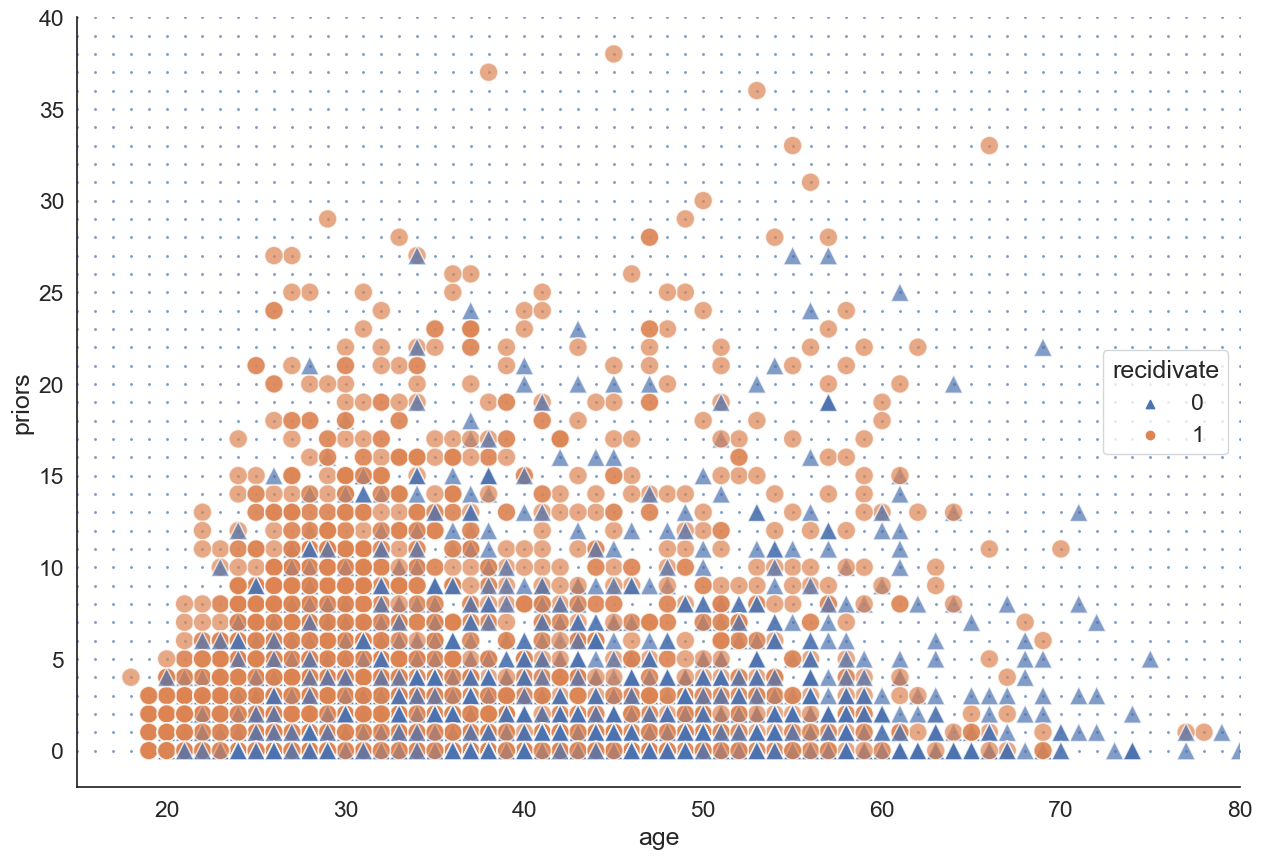

In [29]:
i = [j for j in range(0, 101)]
j = [i for i in range(0, 41)]
x = [[k] * len(j) for k in i]
flat_list = [item for sublist in x for item in sublist]

d = pd.DataFrame({"age": flat_list, "priors": j * len(i)})
d["grid"] = "grid"
d

fig, ax = plt.subplots(figsize=(15, 10))
sns.scatterplot(x="age", y="priors", data=d, s=5, ax=ax, alpha=0.7)
ax.set_xlim(left=15, right=80)
ax.set_ylim(bottom=-2, top=40)
sns.despine()
sns.scatterplot(
    x="age",
    y="priors",
    hue="recidivate",
    style="recidivate",
    s=180,
    data=dfc.sample(frac=1),
    ax=ax,
    markers=["^", "o"],
    alpha=0.7,
)

In [30]:
dfc["priors"].min()

0

## Setting up the toy dataset

In [31]:
new = pd.DataFrame(
    [
        [0, 19, 0, 1],
        [0, 20, 0, 1],
        [0, 21, 0, 1],
        [0, 22, 0, 1],
        [0, 22, 3, 1],
        [0, 18, 3, 1],
        [1, 18, 1, 1],
        [0, 19, 0, 1],
        [0, 20, 1, 1],
        [0, 20, 4, 1],
        [0, 20, 2, 1],
        [0, 22, 2, 1],
        [0, 25, 1, 1],
        [0, 22, 1, 1],
        [0, 18, 5, 1],
        [0, 19, 8, 1],
        [0, 21, 9, 1],
        [0, 23, 7, 1],
        [0, 22, 10, 1],
        [0, 26, 4, 1],
        [0, 30, 3, 0],
        [0, 30, 2, 0],
        [1, 45, 1, 0],
        [1, 45, 3, 0],
        [1, 40, 1, 0],
        [1, 40, 2, 0],
        [0, 36, 0, 0],
        [0, 32, 1, 0],
        [0, 40, 0, 0],
        [0, 31, 1, 0],
        [0, 35, 3, 0],
        [0, 31, 0, 0],
        [0, 32, 0, 0],
        [0, 33, 0, 0],
        [0, 40, 7, 0],
        [0, 42, 6, 0],
        [0, 35, 4, 0],
    ],
    columns=["sex", "age", "priors", "recidivate"],
)

print(len(new))
new["grid"] = "training"
new.head()

37


,sex,age,priors,recidivate,grid
0,0,19,0,1,training
1,0,20,0,1,training
2,0,21,0,1,training
3,0,22,0,1,training
4,0,22,3,1,training


In [32]:
toy = pd.concat([d, new])
toy.head()

,age,priors,grid,sex,recidivate
0,0,0,grid,NaN,NaN
1,0,1,grid,NaN,NaN
2,0,2,grid,NaN,NaN
3,0,3,grid,NaN,NaN
4,0,4,grid,NaN,NaN


In [33]:
plot_title = alt.TitleParams(
    "Classifying shapes",
    subtitle=["Using a larger dataset!"],
)

plot_title = alt.TitleParams(
    "Classifying shapes",
    subtitle=["Using the entire dataset!"],
)

top = (
    alt.Chart(dfc2)
    .mark_point(size=5, opacity=0.4, clip=True)
    .encode(
        alt.X(
            "age",
            scale=alt.Scale(
                domain=[0, 90],
                nice=False,
            ),
            axis=alt.Axis(grid=True),
            title="Number of Dots",
        ),
        alt.Y(
            "priors",
            scale=alt.Scale(domain=[-2, 40], nice=False),
            axis=alt.Axis(values=list(np.arange(-2, 45)[2::5])),
            title="Number of Vertices",
        ),
        alt.Color("recidivate:N", legend=None),
    )
).properties(title=plot_title, width=420, height=200)

chart = (
    alt.Chart(dfc2)
    .mark_point(size=5, opacity=0.4, clip=True)
    .encode(
        alt.X(
            "age",
            scale=alt.Scale(
                domain=[0, 90],
                nice=False,
            ),
            axis=alt.Axis(grid=True),
            title="Dots",
        ),
        alt.Y(
            "priors",
            scale=alt.Scale(domain=[-2, 40], nice=False),
            axis=alt.Axis(values=list(np.arange(-2, 45)[2::5])),
            title="Number of Vertices",
        ),
        alt.Color("recidivate:N", legend=None),
        alt.Facet(
            "recidivate:N",
            title="Group 1 or Group 0",
            header=alt.Header(labelFontSize=0),
            sort="descending",
        ),
    )
).properties(width=200, height=200)

final = (
    (top & chart)
    .configure_title(anchor="start", fontSize=20)
    .configure_axis(labelFontSize=12, titleFontSize=16)
)

final

alt.VConcatChart(...)

In [34]:
final.save("../imgs/originals/train.png", scale_factor=2, webdriver="firefox")

## Do the Learning

In [35]:
sc_X = StandardScaler()

# Subset to get the actual training data (new)
X_train = sc_X.fit_transform(subset(toy[toy["grid"] == "training"], ["age", "priors"]))
y_train = subset(toy[toy["grid"] == "training"], ["recidivate"])

# Subset the "test" data as the grid data
X_test = sc_X.transform(subset(toy[toy["grid"] == "grid"], ["age", "priors"]))

# Define the model
classifier = KNeighborsClassifier(n_neighbors=3, p=2, metric="euclidean")

# Fit model
classifier.fit(X_train, y_train)

/Users/firasm/.pyenv/versions/3.10.2/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier(metric='euclidean', n_neighbors=3)

In [36]:
## Predict results

y_pred = classifier.predict(X_test)
grid = pd.DataFrame(X_test, columns=["age", "priors"])
grid["recidivate"] = y_pred
d["recidivate"] = y_pred

toy = pd.concat([d, new])
toy.head()

,age,priors,grid,recidivate,sex
0,0,0,grid,1.0,NaN
1,0,1,grid,1.0,NaN
2,0,2,grid,1.0,NaN
3,0,3,grid,1.0,NaN
4,0,4,grid,1.0,NaN


In [37]:
plot_title = alt.TitleParams(
    "Classifying a shape as Group 1 (Orange) or Group 0 (Blue)",
    subtitle=["Creating a Decision Boundary"],
)

bg = (
    alt.Chart(toy[toy["grid"] == "grid"])
    .mark_square(size=250, opacity=0.2, clip=True)
    .encode(
        alt.X(
            "age",
            title="Number of Dots",
            scale=alt.Scale(
                domain=[0, 50],
            ),
            axis=alt.Axis(grid=False),
        ),
        alt.Y(
            "priors",
            title="Number of Vertices",
            scale=alt.Scale(domain=[0, 15]),
            axis=alt.Axis(grid=False),
        ),
        alt.Color("recidivate:N", title=""),
    )
)

chart = (
    alt.Chart(toy[toy["grid"] == "training"])
    .mark_circle(size=50, opacity=1, clip=True)
    .encode(
        alt.X(
            "age",
            scale=alt.Scale(
                domain=[0, 50],
            ),
            axis=alt.Axis(grid=False),
        ),
        alt.Y("priors", scale=alt.Scale(domain=[0, 15]), axis=alt.Axis(grid=False)),
        alt.Color("recidivate:N", legend=None),
    )
).properties(title=plot_title, height=250)
chart_bg = (chart + bg).configure_title(anchor="start")
chart_bg

alt.LayerChart(...)

In [38]:
chart_bg.save("../imgs/originals/boundary.png", scale_factor=2, webdriver="firefox")



https://github.com/data-8/textbook/blob/main/chapters/17/1/Nearest_Neighbors.ipynb

## Try to make a 3D plot with plotly

In [39]:
toy

,age,priors,grid,recidivate,sex
0,0,0,grid,1.0,NaN
1,0,1,grid,1.0,NaN
2,0,2,grid,1.0,NaN
3,0,3,grid,1.0,NaN
4,0,4,grid,1.0,NaN
...,...,...,...,...,...
32,32,0,training,0.0,0.0
33,33,0,training,0.0,0.0
34,40,7,training,0.0,0.0
35,42,6,training,0.0,0.0


In [40]:
train

NameError: name 'train' is not defined

In [ ]:
import plotly.express as px


fig = px.scatter_3d(
    # toy[toy["grid"] == "training"],
    toy.dropna(),
    x="age",
    y="priors",
    z="sex",
    color="recidivate",
    color_continuous_scale=["blue", "orange"],
    width=800,
    height=600,
    labels={
        "age": "Number of Vertices",
        "priors": "Number of Dots",
        "sex": "Blob or Pointy",
        "recidivate": "Group 1 (orange) or Group 0 (blue)",
    },
    title="3D view of Features and Target",
)

fig.update_layout(
    scene=dict(
        # xaxis=dict(
        #     nticks=4,
        #     range=[-100, 100],
        # ),
        # yaxis=dict(
        #     nticks=4,
        #     range=[-50, 100],
        # ),
        zaxis=dict(
            nticks=2,
            range=[-0.05, 1],
        ),
    )
)
fig.update_traces(marker_size=4)
fig.update_layout(coloraxis_showscale=False)
fig.show()

In [ ]:
dict(
    # xaxis=dict(
    #     nticks=4,
    #     range=[-100, 100],
    # ),
    # yaxis=dict(
    #     nticks=4,
    #     range=[-50, 100],
    # ),
    zaxis=dict(
        nticks=2,
        range=[0, 1],
    ),
),

## Prepare data exports

### Toy Data

In [ ]:
obscure = {
    "age": "dots",
    "priors": "vertices",
    "sex": "blob",
    "recidivate": "stroke",
}

In [ ]:
toy2 = (
    toy[toy["grid"] == "training"]
    .rename(columns=obscure)
    .astype(int, errors="ignore")
    .filter(list(obscure.values()))
)

toy2.to_csv("../data/trial_data.csv", index=None)

In [ ]:
toy["grid"].unique()

In [ ]:
toy2.head()

### Real fake data

In [ ]:
dfc_1 = subset(dfc, ["age", "priors", "sex", "recidivate"]).rename(columns=obscure)
dfc_1

In [ ]:
train, test = train_test_split(dfc_1, test_size=0.2)

In [ ]:
train.mean().to_dict()

In [ ]:
train.std().to_dict()

In [ ]:
test

In [ ]:
train.to_csv("../data/train.csv", index=None)
test.to_csv("../data/test.csv", index=None)

- What "features" of the shape might be important?

### Creating a Boundary

It becomes clear that if you were to map the entire plane (here 2D, but in reality, 3D), a boundary forms.
Here's what that looks like with the current classifier and the current data:

<img src="../imgs/boundary.png" width=60%>

**Caption**: Iteratively mapping the 2D plane using the training data allows us to create regions to categorize unseen data points into classes.

Quite often, decision boundaries are not that clear (otherwise we wouldn't need machine learning!) and the more data (and classes) there are, the more likely it is that boundaries are complex!